In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("./utils"))
import numpy as np
import matplotlib.pyplot as plt
import model1 as model_module
import image as img_module
import mask as mask_module
import model2 as model2_module
import yolo as yolo_module
import torch

model_module.time_show()
model_module.load_model("vit_b", "ckpt/vit_b.pth")
model2_module.load_model()

Time will be shown
Loading model
Using SAM
Model loaded
Time taken to load model:  1.7821307182312012
load gaze estimator
load the pre-trained model:  ckpt/epoch_24_ckpt.pth.tar


detected_faces:  2
pred_gaze_np:  [   -0.44908     0.60768]

0: 480x640 9 persons, 2 bottles, 7 chairs, 5 dining tables, 3 laptops, 43.4ms
Speed: 5.8ms preprocess, 43.4ms inference, 203.8ms postprocess per image at shape (1, 3, 480, 640)
Generating mask
Time taken to generate mask:  4.8098304271698


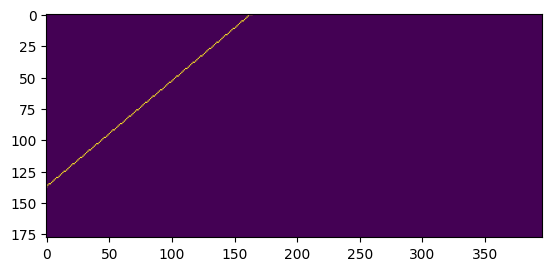

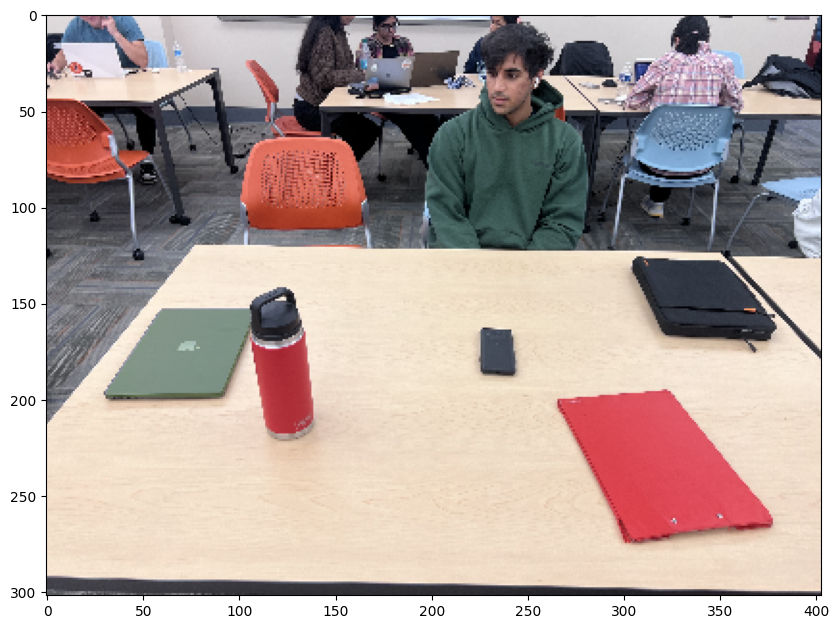

In [3]:
for file in os.listdir("./data"):
    if file.endswith(".jpeg") or file.endswith(".png"):
        if file != "IMG_7764.jpeg":
            continue
        image_path = os.path.join("./data", file)   
        img, small = img_module.load_img(image_path)
        img_module.set_img(small)
       
        # gaze estimation
        arrow_start, arrow_end = model2_module.find_vector_arrow(img)

        # yolo implementation (finds table)
        table_img, table_bbox = yolo_module.get_table(small)
        reset_table_bbox = torch.tensor([0, 0, table_bbox[2]-table_bbox[0], table_bbox[3]-table_bbox[1]])
        
        #segmentation
        masks = model_module.mask_generate(table_img)
        masks_on_table = mask_module.find_object_given_table(reset_table_bbox, masks)
        if len(masks_on_table) == 0:
            print("No object on table")
            continue
        mask_line = img_module.get_mask_line_yolo(arrow_start, arrow_end, table_img, False)
        plt.imshow(mask_line)
        for mask in masks_on_table:
            seg = mask["segmentation"]
            if np.sum(seg & mask_line) > 0:
                img_module.show_anns_yolo([mask], table_bbox, False, file)
                # img_module.show_box(mask["bbox"])
                break